In [1]:
import sys

In [2]:
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install regex
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn

In [3]:
import os
import pandas as pd
import numpy as np 
from re import search

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings("ignore")

<h3>Importing the dataset</h3>

In [6]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
result_dir = os.path.join(cwd,'Results')

In [7]:
modelname = ['GBC','LR','MNB','RFC','SVM']
modelnamebase = ['GBC','LR','MNB','RFC','SVM']

In [8]:
test_res = []
train_res = []
valid_res = []

In [9]:
base_test_res = []
base_train_res = []
base_valid_res = []

<h3>Result Processing</h3>

<h4>Base</h4>

In [10]:
for model in modelnamebase:
    base_train_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Train_result.csv'))
    base_test_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Test_result.csv'))
    
    unnamed_columns = [col for col in base_test_df.columns if search(r'^Unnamed', col)]
    base_test_df = base_test_df.drop(unnamed_columns, axis=1)
    base_test_df.drop('Time (Sec)', axis=1, inplace=True)
    
    unnamed_columns = [col for col in base_train_df.columns if search(r'^Unnamed', col)]
    base_train_df = base_train_df.drop(unnamed_columns, axis=1)
    base_train_df.drop('Time (Sec)', axis=1, inplace=True)
    
    base_test_df.drop('ID', axis=1, inplace=True)
    base_train_df.drop('ID', axis=1, inplace=True)
    
    base_final_test_res = base_test_df.to_dict(orient='records')[0]
    base_final_test_res['Model'] = model
    base_test_res.append(base_final_test_res)
    
    base_final_train_res = base_train_df.to_dict(orient='records')[0]
    base_final_train_res['Model'] = model
    base_train_res.append(base_final_train_res)

In [11]:
model = 'Voting'
base_train_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Train_result.csv'))
base_test_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Test_result.csv'))

unnamed_columns = [col for col in base_test_df.columns if search(r'^Unnamed', col)]
base_test_df = base_test_df.drop(unnamed_columns, axis=1)
base_test_df.drop('Time (Sec)', axis=1, inplace=True)

unnamed_columns = [col for col in base_train_df.columns if search(r'^Unnamed', col)]
base_train_df = base_train_df.drop(unnamed_columns, axis=1)
base_train_df.drop('Time (Sec)', axis=1, inplace=True)

base_final_test_res = base_test_df.to_dict(orient='records')[0]
base_final_test_res['Model'] = model
base_test_res.append(base_final_test_res)

base_final_train_res = base_train_df.to_dict(orient='records')[0]
base_final_train_res['Model'] = model
base_train_res.append(base_final_train_res)

In [12]:
modelnamebase.append('Voting')

In [13]:
for model in modelnamebase :
    file_path = os.path.join(result_dir,f'BASE\BASE_{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    base_valid_res_mdl = dict()
    base_valid_res_mdl['Accuracy'] = accuracy
    base_valid_res_mdl['F1-Score'] = macro_avg_f1
    base_valid_res_mdl['Recall'] = macro_avg_recall
    base_valid_res_mdl['Precision'] = macro_avg_precision
    base_valid_res_mdl['Model']=model
    
    base_valid_res.append(base_valid_res_mdl)

In [14]:
base_test_res_df = pd.DataFrame(base_test_res)
base_test_res_df['Model'] = base_test_res_df['Model'].astype(str)
base_test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.923610,0.921226,0.933703,0.909124,GBC
1,0.938271,0.935821,0.940805,0.930910,LR
2,0.779387,0.701553,0.542360,0.993514,MNB
3,0.901397,0.893358,0.863458,0.925446,RFC
4,0.955449,0.953688,0.958958,0.948509,SVM
5,0.950290,0.947629,0.940411,0.955032,Voting


In [15]:
base_train_res_df = pd.DataFrame(base_train_res)
base_train_res_df['Model'] = base_train_res_df['Model'].astype(str)
base_train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.938617,0.936771,0.950572,0.923365,GBC
1,0.965926,0.964425,0.965535,0.963319,LR
2,0.824251,0.775571,0.634866,0.996439,MNB
3,1.000000,1.000000,1.000000,1.000000,RFC
4,0.997829,0.997733,0.998619,0.996849,SVM
5,0.992622,0.992250,0.987438,0.997111,Voting


In [16]:
base_valid_res_df = pd.DataFrame(base_valid_res)
base_valid_res_df['Model'] = base_valid_res_df['Model'].astype(str)
base_valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.92776,0.92761,0.92809,0.92731,GBC
1,0.93657,0.93633,0.93604,0.93669,LR
2,0.80695,0.79455,0.79574,0.86391,MNB
3,0.90813,0.90745,0.90617,0.91039,RFC
4,0.95620,0.95604,0.95579,0.95635,SVM
5,0.94916,0.94889,0.94810,0.95019,Voting


<h4>Hyper Tuned</h4>

In [17]:
for model in modelname :
    train_df = pd.read_csv(os.path.join(result_dir,f'{model}_Train_result.csv'))
    test_df = pd.read_csv(os.path.join(result_dir,f'{model}_Test_result.csv'))
    parameter_df = pd.read_csv(os.path.join(result_dir,f'{model}_Parameters.csv'))
    
    unnamed_columns = [col for col in test_df.columns if search(r'^Unnamed', col)]
    test_df = test_df.drop(unnamed_columns, axis=1)
    test_columns = list(test_df.columns)
    
    test_top_ten = pd.DataFrame()
    test_top_ten = test_top_ten.append(test_df.nlargest(1, ['Accuracy']), ignore_index = True)
    test_top_ten.columns = test_columns
    test_top_ten.drop('Time (Sec)', axis=1, inplace=True)
    '''
    print('Test')
    print(test_top_ten)
    '''
    ID_list = list(test_top_ten['ID'])
    
    unnamed_columns = [col for col in train_df.columns if search(r'^Unnamed', col)]
    train_df = train_df.drop(unnamed_columns, axis=1)
    train_columns = list(train_df.columns)
    
    train_ten = pd.DataFrame()
    for ID in ID_list :
        train_ten = train_ten.append([train_df[train_df.ID == ID]], ignore_index = True)
    train_ten.columns = train_columns
    train_ten.drop('Time (Sec)', axis=1, inplace=True)
    '''
    print('Train')
    print(train_ten)
    '''
    unnamed_columns = [col for col in parameter_df.columns if search(r'^Unnamed', col)]
    parameter_df = parameter_df.drop(unnamed_columns, axis=1)
    parameter_columns = list(parameter_df.columns)
    '''
    parameter_ten = pd.DataFrame()
    for ID in ID_list :
        parameter_ten = parameter_ten.append([parameter_df[parameter_df.ID == ID]], ignore_index = True)
    parameter_ten.columns = parameter_columns
    
    print(f'Parameters {model}')
    print(parameter_ten)
    print('\n')
    '''
    final_test_res = dict(test_top_ten.mean())
    final_test_res['Model'] = model
    test_res.append(final_test_res)
    
    final_train_res = dict(train_ten.mean())
    final_train_res['Model'] = model
    train_res.append(final_train_res)

In [18]:
model = 'Voting'
train_df = pd.read_csv(os.path.join(result_dir,f'{model}_Train_result.csv'))
test_df = pd.read_csv(os.path.join(result_dir,f'{model}_Test_result.csv'))

unnamed_columns = [col for col in test_df.columns if search(r'^Unnamed', col)]
test_df = test_df.drop(unnamed_columns, axis=1)
test_columns = list(test_df.columns)

test_top_ten = pd.DataFrame()
test_top_ten = test_top_ten.append(test_df, ignore_index = True)
test_top_ten.columns = test_columns
test_top_ten.drop('Time (Sec)', axis=1, inplace=True)

print('Test')
print(test_top_ten)

unnamed_columns = [col for col in train_df.columns if search(r'^Unnamed', col)]
train_df = train_df.drop(unnamed_columns, axis=1)
train_columns = list(train_df.columns)

train_ten = pd.DataFrame()
train_ten = train_ten.append(train_df, ignore_index = True)
train_ten.columns = train_columns
train_ten.drop('Time (Sec)', axis=1, inplace=True)

print('Train')
print(train_ten)

final_test_res = dict(test_top_ten.mean())
final_test_res['Model'] = model
test_res.append(final_test_res)

final_train_res = dict(train_ten.mean())
final_train_res['Model'] = model
train_res.append(final_train_res)

Test
   Accuracy  F1-Score    Recall  Precision
0  0.963755  0.961921  0.957116   0.966829
Train
   Accuracy  F1-Score  Recall  Precision
0  0.999874  0.999868     1.0   0.999737


In [19]:
modelname.append('Voting')

In [20]:
for model in modelname :
    file_path = os.path.join(result_dir,f'{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    valid_res_mdl = dict()
    valid_res_mdl['Accuracy'] = accuracy
    valid_res_mdl['F1-Score'] = macro_avg_f1
    valid_res_mdl['Recall'] = macro_avg_recall
    valid_res_mdl['Precision'] = macro_avg_precision
    valid_res_mdl['Model']=model
    
    valid_res.append(valid_res_mdl)

In [21]:
test_res_df = pd.DataFrame(test_res)
test_res_df['Model'] = test_res_df['Model'].astype(str)
test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.964888,0.963348,0.964615,0.962140,GBC
1,0.957966,0.956200,0.959090,0.953340,LR
2,0.907564,0.897289,0.844385,0.957336,MNB
3,0.908382,0.901266,0.874113,0.930177,RFC
4,0.959665,0.957993,0.961326,0.954730,SVM
5,0.963755,0.961921,0.957116,0.966829,Voting


In [22]:
train_res_df = pd.DataFrame(train_res)
train_res_df['Model'] = train_res_df['Model'].astype(str)
train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.999874,0.999868,1.000000,0.999737,GBC
1,1.000000,1.000000,1.000000,1.000000,LR
2,0.974751,0.973114,0.955242,0.991670,MNB
3,0.999276,0.999244,0.999901,0.998588,RFC
4,1.000000,1.000000,1.000000,1.000000,SVM
5,0.999874,0.999868,1.000000,0.999737,Voting


In [23]:
valid_res_df = pd.DataFrame(valid_res)
valid_res_df['Model'] = valid_res_df['Model'].astype(str)
valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.95872,0.95858,0.95848,0.95869,GBC
1,0.95469,0.95455,0.95447,0.95463,LR
2,0.91140,0.91021,0.90781,0.91931,MNB
3,0.91040,0.90980,0.90868,0.91214,RFC
4,0.95998,0.95984,0.95970,0.96000,SVM
5,0.96275,0.96259,0.96210,0.96326,Voting


<h3>Graphing</h3>

In [24]:
graph_dir = os.path.join(cwd,'Graphs')

<h3>Base</h3>

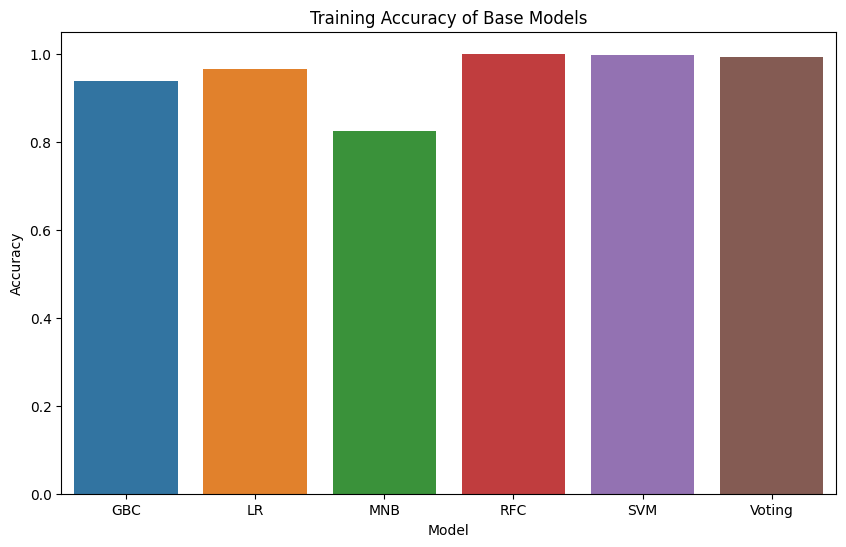

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_train_res_df)
title='Training Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

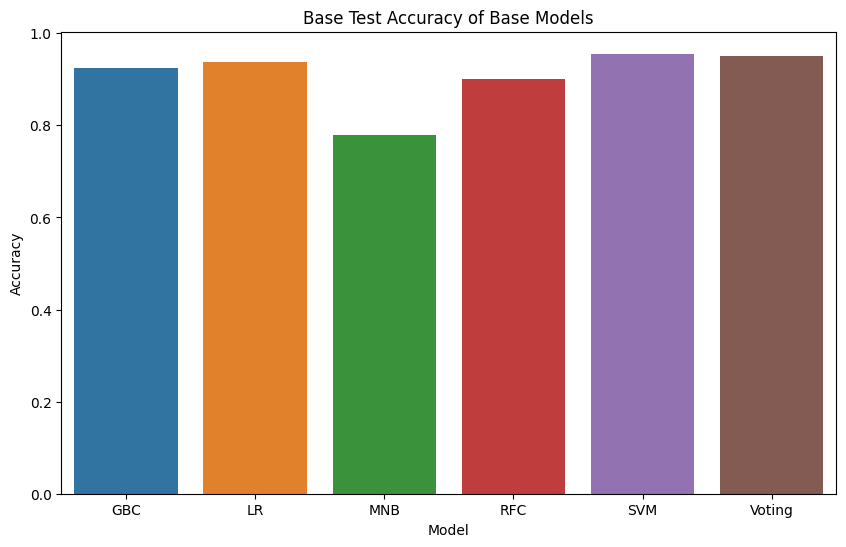

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_test_res_df)
title = 'Base Test Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

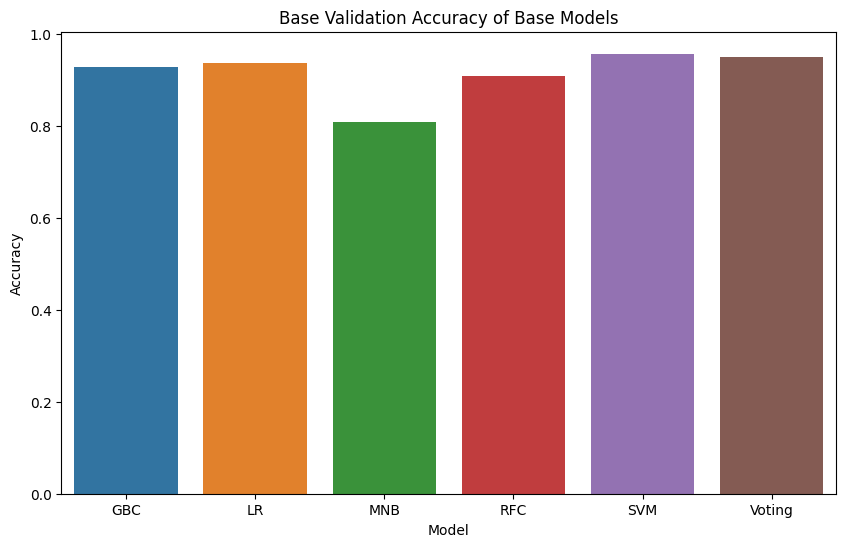

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_valid_res_df)
title='Base Validation Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

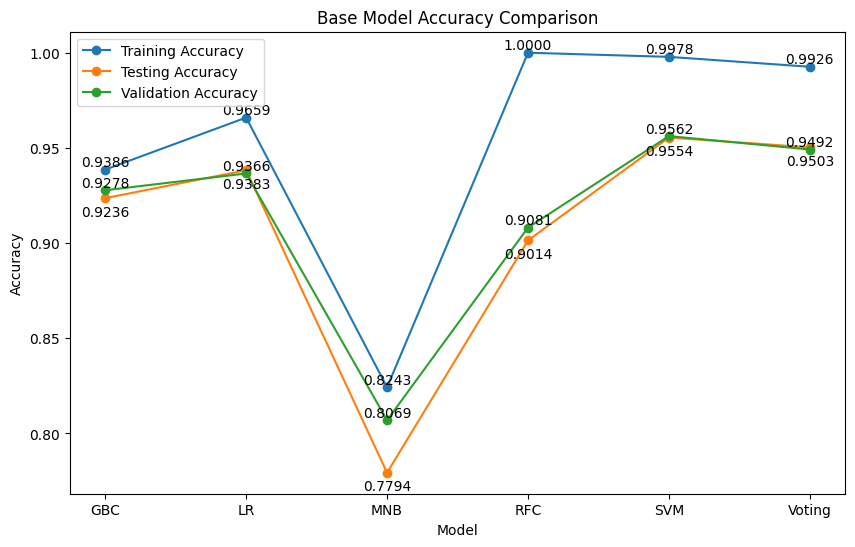

In [28]:
merged_base_df = pd.merge(base_train_res_df, base_test_res_df, on='Model', suffixes=('_train', '_test'))
merged_base_df = pd.merge(merged_base_df, base_valid_res_df, on='Model')

plt.figure(figsize=(10, 6))

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy_train']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy_test']):
    plt.text(x, y-0.011, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

title = 'Base Model Accuracy Comparison'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

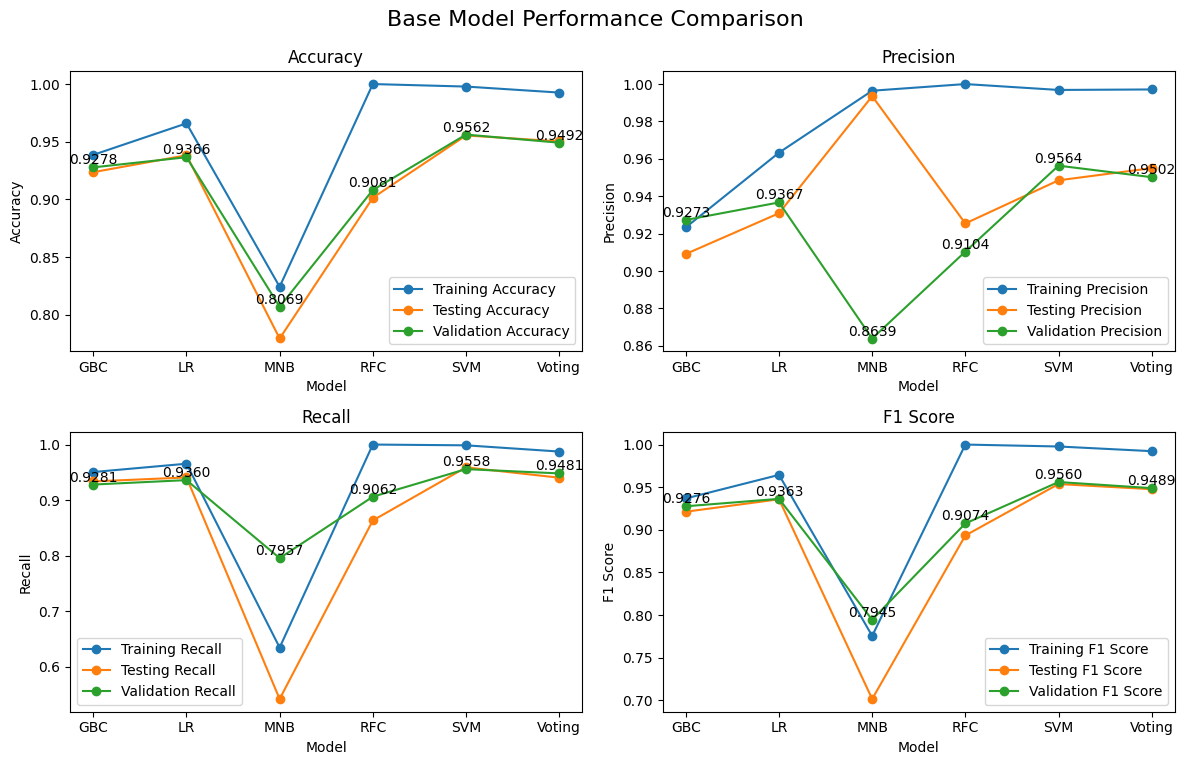

In [29]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Accuracy subgraph
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy_train'], marker='o', label='Training Accuracy')
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy_test'], marker='o', label='Testing Accuracy')
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy'], marker='o', label='Validation Accuracy')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy']):
    axes[0, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Precision subgraph
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision_train'], marker='o', label='Training Precision')
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision_test'], marker='o', label='Testing Precision')
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision'], marker='o', label='Validation Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Precision']):
    axes[0, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Recall subgraph
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall_train'], marker='o', label='Training Recall')
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall_test'], marker='o', label='Testing Recall')
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall'], marker='o', label='Validation Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Recall']):
    axes[1, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# F1 Score subgraph
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score_train'], marker='o', label='Training F1 Score')
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score_test'], marker='o', label='Testing F1 Score')
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score'], marker='o', label='Validation F1 Score')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['F1-Score']):
    axes[1, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and display the graph
title = 'Base Model Performance Comparison'
plt.suptitle(title, fontsize=16)
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

<h3>Hyper Tuned</h3>

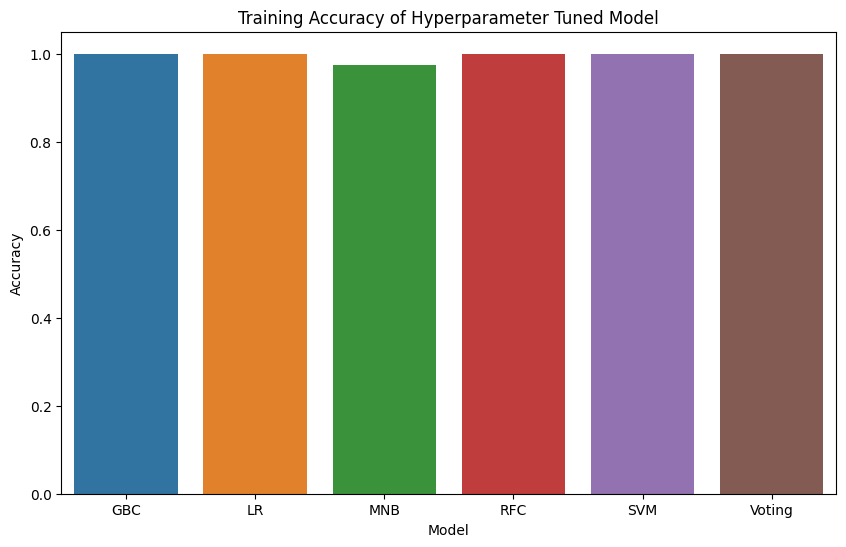

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=train_res_df)
title='Training Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

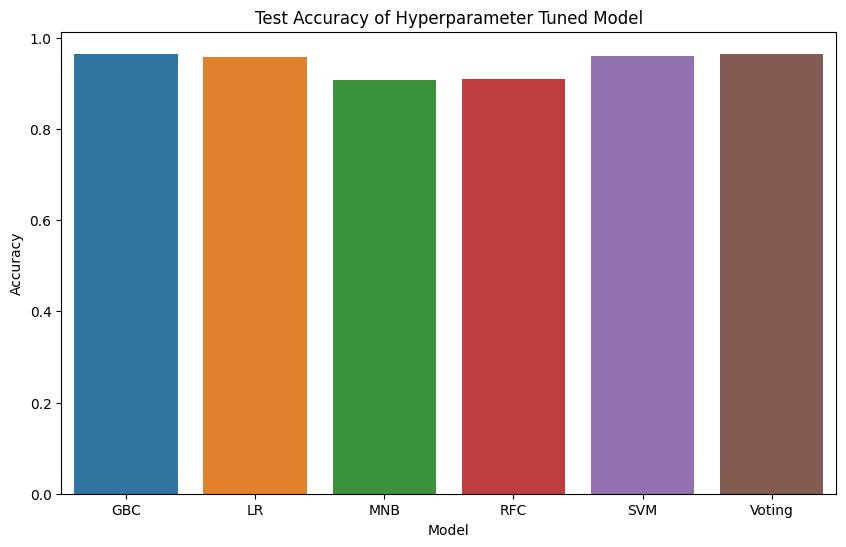

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=test_res_df)
title = 'Test Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

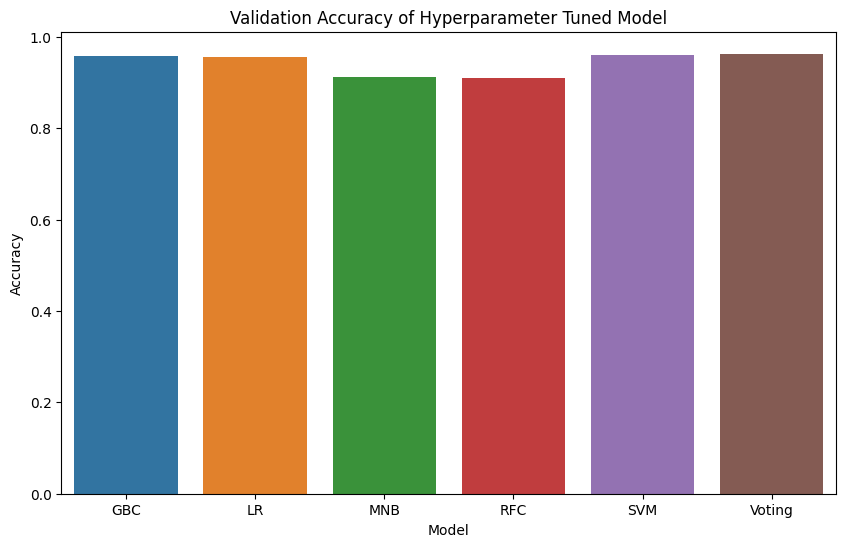

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=valid_res_df)
title='Validation Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

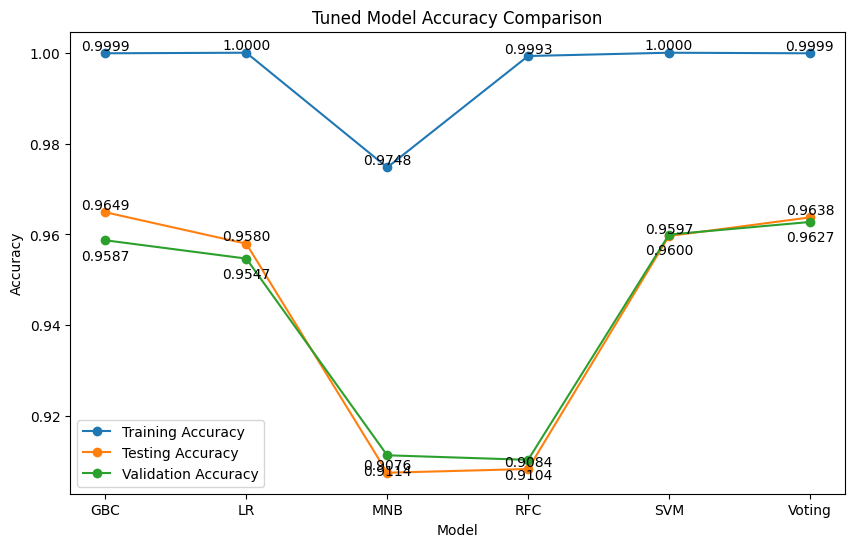

In [33]:
merged_tuned_df = pd.merge(train_res_df, test_res_df, on='Model', suffixes=('_train', '_test'))
merged_tuned_df = pd.merge(merged_tuned_df, valid_res_df, on='Model')

plt.figure(figsize=(10, 6))

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy']):
    plt.text(x, y-0.005, f'{y:.4f}', ha='center', va='bottom')

title='Tuned Model Accuracy Comparison'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

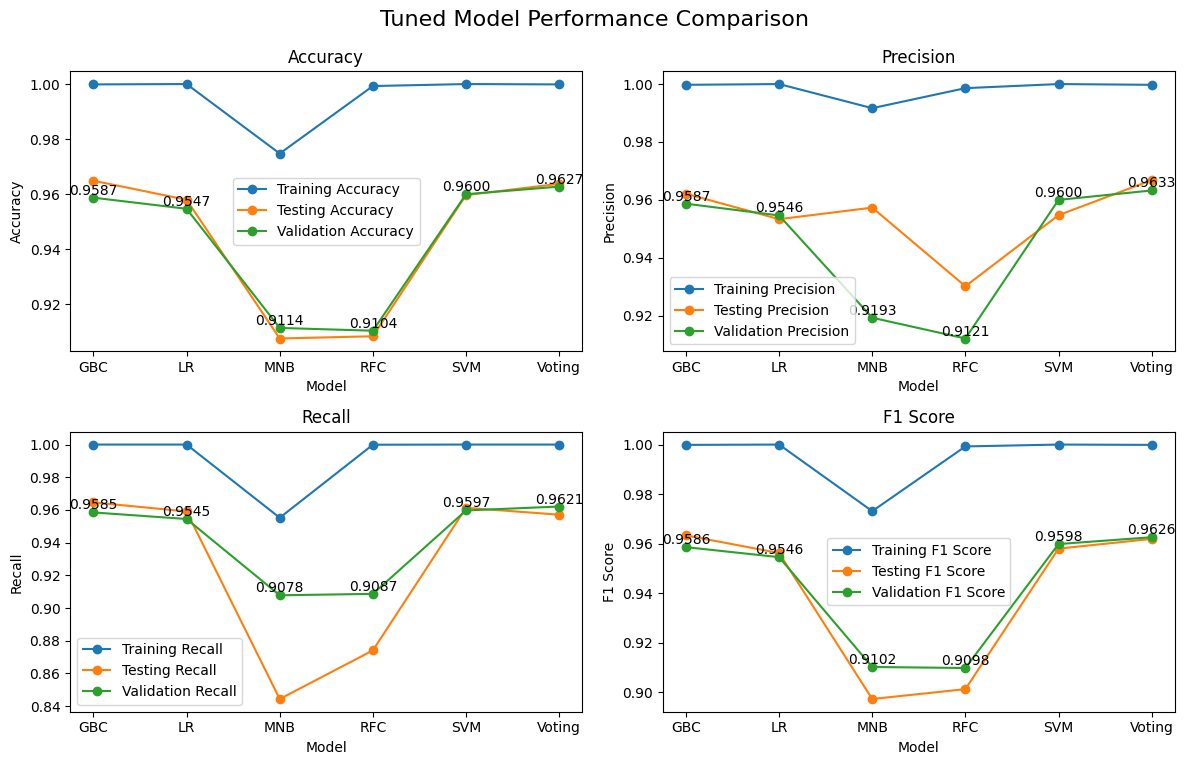

In [34]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Accuracy subgraph
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train'], marker='o', label='Training Accuracy')
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test'], marker='o', label='Testing Accuracy')
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy'], marker='o', label='Validation Accuracy')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy']):
    axes[0, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Precision subgraph
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision_train'], marker='o', label='Training Precision')
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision_test'], marker='o', label='Testing Precision')
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision'], marker='o', label='Validation Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Precision']):
    axes[0, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Recall subgraph
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall_train'], marker='o', label='Training Recall')
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall_test'], marker='o', label='Testing Recall')
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall'], marker='o', label='Validation Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Recall']):
    axes[1, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# F1 Score subgraph
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score_train'], marker='o', label='Training F1 Score')
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score_test'], marker='o', label='Testing F1 Score')
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score'], marker='o', label='Validation F1 Score')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['F1-Score']):
    axes[1, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and display the graph
title = 'Tuned Model Performance Comparison'
plt.suptitle(title, fontsize=16)
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

<h3>Others</h3>

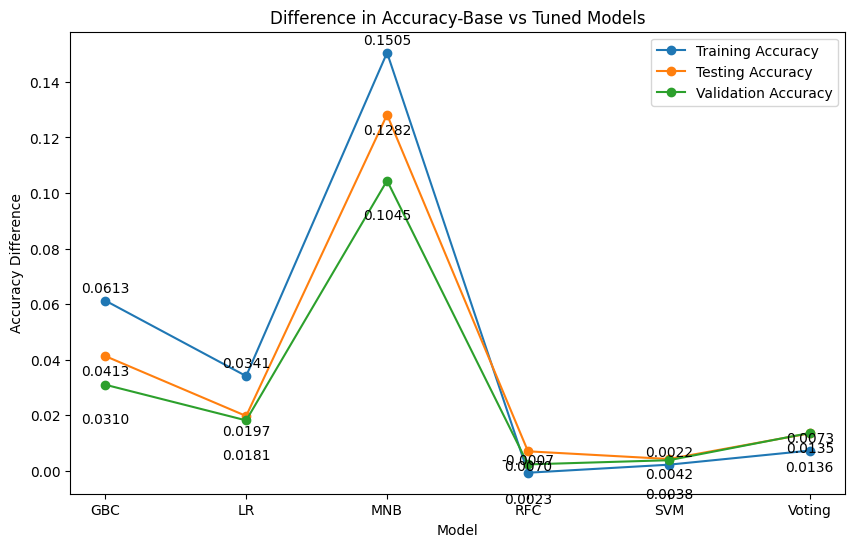

In [36]:
# Calculate the difference in accuracies between base and tuned models
merged_diff_df = pd.DataFrame()
merged_diff_df['Model'] = merged_base_df['Model']
merged_diff_df['Diff_Accuracy_train'] = merged_tuned_df['Accuracy_train'] - merged_base_df['Accuracy_train']
merged_diff_df['Diff_Accuracy_test'] = merged_tuned_df['Accuracy_test'] - merged_base_df['Accuracy_test']
merged_diff_df['Diff_Accuracy'] = merged_tuned_df['Accuracy'] - merged_base_df['Accuracy']

# Plot the difference in accuracies
plt.figure(figsize=(10, 6))

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_train']):
    plt.text(x, y+0.002, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_test']):
    plt.text(x, y-0.008, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy']):
    plt.text(x, y-0.015, f'{y:.4f}', ha='center', va='bottom')

title = 'Difference in Accuracy-Base vs Tuned Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy Difference')

plt.legend()
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()